# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML/tano_signal/
!ls

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML/tano_signal


# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys
import os
import copy
import math

import importlib


import numpy as np
import pandas as pd

from astropy.io  import fits
from astropy        import units as u
from astropy.wcs import WCS

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path

from spectral_cube import SpectralCube

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct101_checkpoint_path = checkpoint_path / 'c101'
cnn101_checkpoint_path = checkpoint_path / 'cnn' / 'c101'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'
img_path = tanosignal_path / 'imgs'

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]

    dat.close()

    print(f"Cube shape: {c.shape}") # (vlsr, b, l)

    del dat

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]      # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]      # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def plot_trends(x, y):
    # Plot
    fig = plt.figure(figsize=(18, 10))


    ax = fig.add_subplot(221)

    sct = ax.scatter(x, y,
                      zorder=2, s=10,
                      alpha=0.5,
                      marker='o', c='k',
                      label='')



    img = ax.hexbin(x, y, gridsize=100, cmap='gray', norm=LogNorm())

    axins1 = inset_axes(ax,
                        width="2%",
                        height="70%",
                        loc="upper left",
                        )
    axins1.xaxis.set_ticks_position("bottom")
    cbar = fig.colorbar(img,
                        cax=axins1,
                        orientation='vertical',
                        fraction=0.02,
                        pad=0.01, aspect=95)
    cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=10)


    ax.set_xlabel(r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=20)
    ax.set_ylabel(r'${f_\mathrm{CNM}}$', fontsize=20, fontweight='normal')

    ax.tick_params(axis='x', labelsize=14, pad=4)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




    # Axis 2
    ax = fig.add_subplot(222)

    sct = ax.scatter(x, y,
                      zorder=1, s=10,
                      alpha=0.5,
                      marker='o', c='k',
                      label='')



    img = ax.hexbin(x, y, gridsize=100, cmap='gray', norm=LogNorm())

    axins1 = inset_axes(ax,
                        width="2%",
                        height="70%",
                        loc="upper left",
                        )
    axins1.xaxis.set_ticks_position("bottom")
    cbar = fig.colorbar(img,
                        cax=axins1,
                        orientation='vertical',
                        fraction=0.02,
                        pad=0.01, aspect=95)
    cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=10)


    ax.set_xlabel(r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=20)
    ax.set_ylabel(r'${\mathcal{R}_\mathrm{HI}}$', fontsize=20, fontweight='normal')

    ax.tick_params(axis='x', labelsize=14, pad=4)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)

    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




    # Axis 3
    ax = fig.add_subplot(223)
    sct = ax.scatter(xx, y,
                      zorder=1, s=10,
                      alpha=0.5,
                      marker='o', c='k',
                      label='')

    img = ax.hexbin(xx, y, gridsize=100, cmap='gray', norm=LogNorm())

    axins1 = inset_axes(ax,
                        width="2%",
                        height="75%",
                        loc="upper left",
                        )
    axins1.xaxis.set_ticks_position("bottom")
    cbar = fig.colorbar(img,
                        cax=axins1,
                        orientation='vertical',
                        fraction=0.02,
                        pad=0.01, aspect=95)
    cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=9)

    ax.set_xlabel(r'$T_\mathrm{B, max}$ [K]', fontsize=20)
    ax.set_ylabel(r'${f_\mathrm{CNM}}$', fontsize=20, fontweight='normal')

    ax.tick_params(axis='x', labelsize=12, pad=4)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)

    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)






    # Axis 4
    ax = fig.add_subplot(224)
    sct = ax.scatter(xx, yy,
                      zorder=1, s=10,
                      alpha=0.5,
                      marker='o', c='k',
                      label='')



    img = ax.hexbin(xx, yy, gridsize=100, cmap='gray', norm=LogNorm())

    axins1 = inset_axes(ax,
                        width="2%",
                        height="75%",
                        loc="upper left",
                        )
    axins1.xaxis.set_ticks_position("bottom")
    cbar = fig.colorbar(img,
                        cax=axins1,
                        orientation='vertical',
                        fraction=0.02,
                        pad=0.01, aspect=95)
    cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=9)


    ax.set_xlabel(r'$T_\mathrm{B, max}$ [K]', fontsize=20)
    ax.set_ylabel(r'${\mathcal{R}_\mathrm{HI}}$', fontsize=20, fontweight='normal')

    ax.tick_params(axis='x', labelsize=12, pad=4)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)

    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)








    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.15,
                        hspace=0.25
                        )


    plt.show()
    plt.close()













def plot_fcnm_trends(x, y, z):
    # Plot
    fig = plt.figure(figsize=(14, 6))


    ax1 = fig.add_subplot(121)

    sct = ax1.scatter(x, z,
                      zorder=1, s=10,
                      alpha=0.5,
                      marker='o', c='k',
                      label='')



    img = ax1.hexbin(x, z, gridsize=100, cmap='gray', norm=LogNorm())

    axins1 = inset_axes(ax1,
                        width="2%",
                        height="50%",
                        loc="upper left",
                        )
    axins1.xaxis.set_ticks_position("bottom")
    cbar = fig.colorbar(img,
                        cax=axins1,
                        orientation='vertical',
                        fraction=0.02,
                        pad=0.01, aspect=95)
    cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=10)


    ax1.set_xlabel(r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=20)
    ax1.set_ylabel(r'${f^{ROHSA}_\mathrm{CNM}}$', fontsize=20, fontweight='normal')

    ax1.tick_params(axis='x', labelsize=14, pad=4)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(which='both', width=2)
    ax1.tick_params(which='major', length=4)
    ax1.tick_params(which='minor', length=2)
    ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=0)









    # Axis 3
    ax2 = fig.add_subplot(122, sharey=ax1)
    sct = ax2.scatter(y, z,
                      zorder=1, s=10,
                      alpha=0.5,
                      marker='o', c='k',
                      label='')



    img = ax2.hexbin(y, z, gridsize=100, cmap='gray', norm=LogNorm())

    axins1 = inset_axes(ax2,
                        width="2%",
                        height="50%",
                        loc="upper left",
                        )
    axins1.xaxis.set_ticks_position("bottom")
    cbar = fig.colorbar(img,
                        cax=axins1,
                        orientation='vertical',
                        fraction=0.02,
                        pad=0.01, aspect=95)
    cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=9)

    ax2.set_xlabel(r'$T_\mathrm{B, max}$ [K]', fontsize=20)
    ax2.set_ylabel(r'', fontsize=20, fontweight='normal')

    ax2.tick_params(axis='x', labelsize=12, pad=4)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.tick_params(which='both', width=2)
    ax2.tick_params(which='major', length=4)
    ax2.tick_params(which='minor', length=2)

    ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=0)



    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.15,
                        hspace=0.25
                        )

    # fig.savefig('', bbox_inches='tight')


    plt.show()
    plt.close()

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

# Read data

In [ ]:
# Observed datasets
filename = 'GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits'
print(filename)

data_file = uma_data_path / filename
data_file

# Spectal res: 1.0 km/s
# Channel spacing: 0.824 km/s

In [ ]:
data, hdr = fits.getdata(data_file, header=True)
data = np.squeeze(data)

hdr['CUNIT3'] = 'm/s'

fits.writeto(data_file, data, hdr, overwrite=True)

In [ ]:
cube, cube_wcs, cube_gl, cube_gb, cube_vlsr, cube_hdr = read_fits_cube(data_file)
print(cube_wcs)
print(cube)

Cube shape: (654, 495, 603)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-GLS' 'GLAT-GLS' 
CRVAL : 140.657081396 0.0 
CRPIX : 305.0 -364.1708374 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.05833333358 0.05833333358 
NAXIS : 0  0
SpectralCube with shape=(654, 495, 603) and unit=K:
 n_x:    603  type_x: GLON-SFL  unit_x: deg    range:   113.546649 deg:  168.313361 deg
 n_y:    495  type_y: GLAT-SFL  unit_y: deg    range:    21.301632 deg:   50.118299 deg
 n_s:    654  type_s: VOPT-F2W  unit_s: m / s  range:  -311210.220 m / s:  214332.215 m / s


In [ ]:
m0 = cube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
nhi_thin_full = np.array(m0)*0.018224

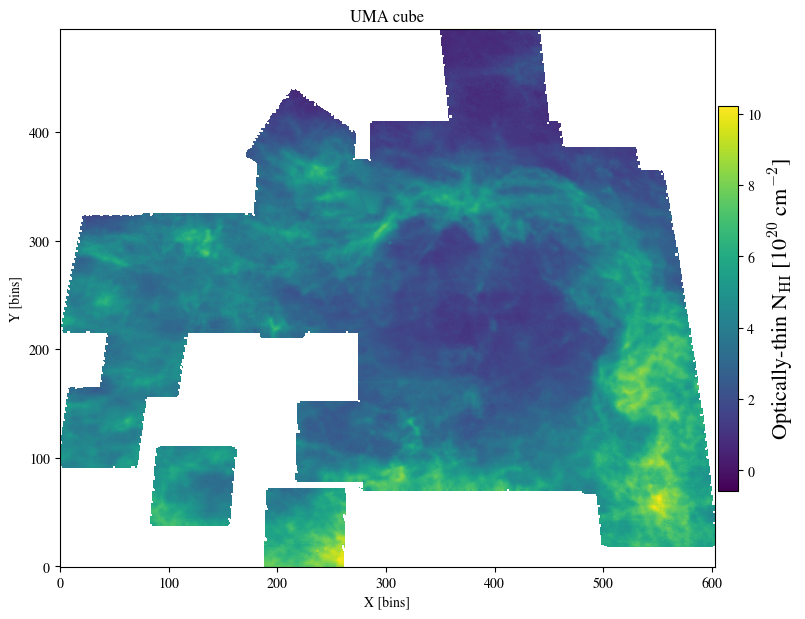

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(nhi_thin_full, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
cube_vlsr = np.array(cube_vlsr)/1000.
dv = np.abs(np.mean(np.diff(cube_vlsr)))
dv

0.8048123037229088

In [ ]:
data, hdr = fits.getdata(data_file, header=True)

data = data[215:369,246:374, 197:325]
data = data[85:, :, :] # data[85:, :, :], [79:, :, :]
data.shape

(69, 128, 128)

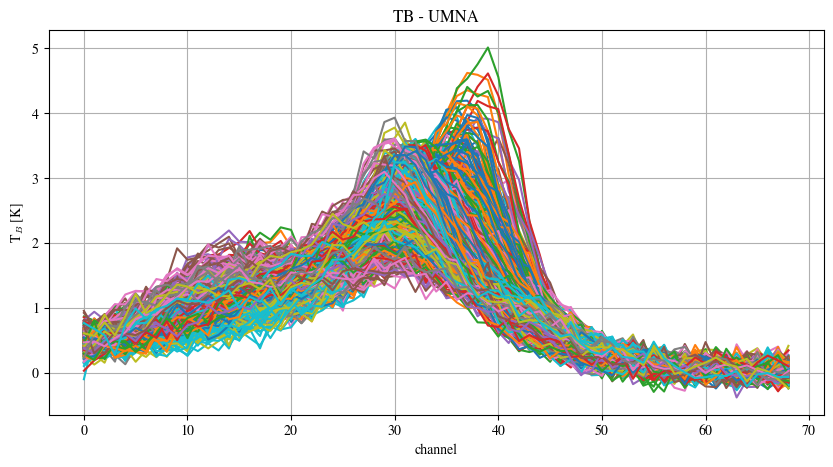

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(data[:, 20+j, 20+i])

plt.title('TB - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
plt.grid()
# fig.savefig('', bbox_inches='tight')
plt.show()

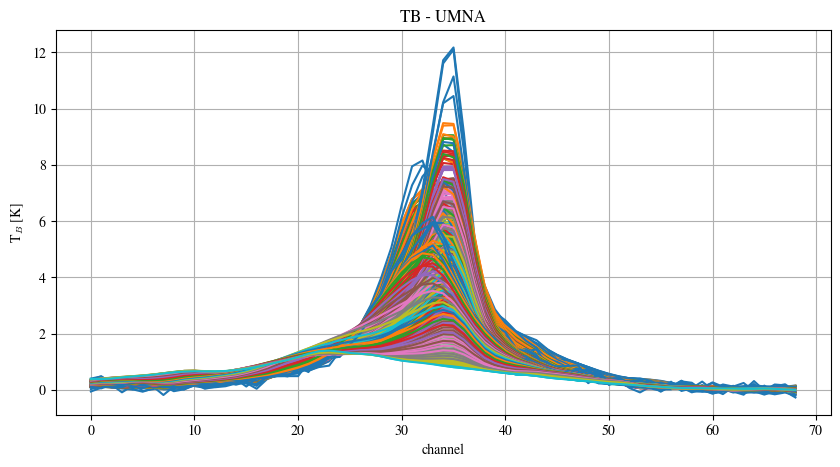

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(data[:, 80+j, 80+i])

plt.title('TB - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
plt.grid()
# fig.savefig('', bbox_inches='tight')
plt.show()

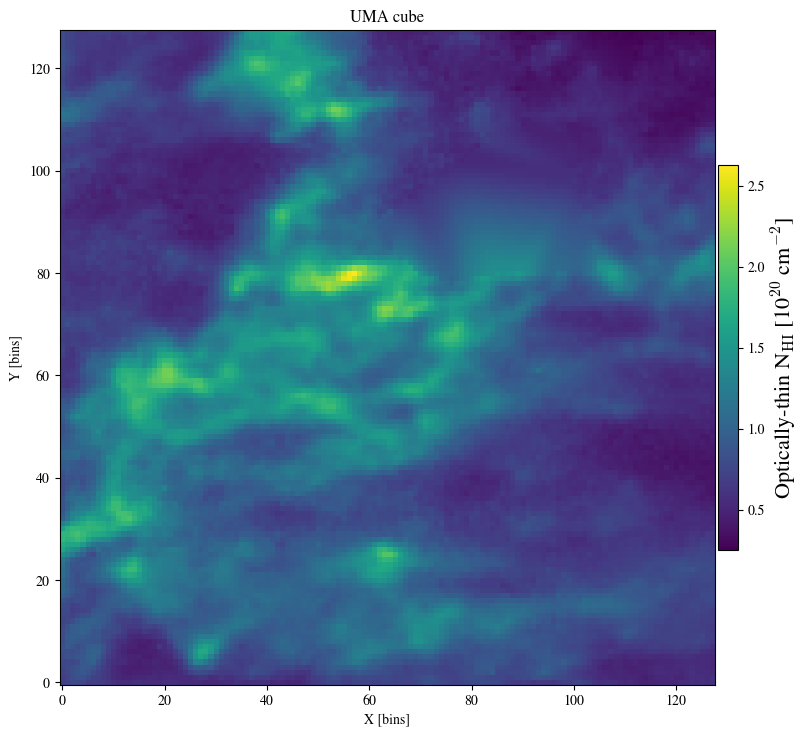

In [ ]:
nhi_thin = 0.018224 * np.sum(data, axis=0) * dv


plt.figure(figsize=(10,10))
plt.imshow(nhi_thin, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

# Subcube

In [ ]:
subcube = cube[215:369,246:374, 197:325]
subcube = subcube[85:, :, :]
subcube.shape

(69, 128, 128)

In [ ]:
subcube_vlsr = subcube.spectral_axis.value/1000.
subcube_vlsr.shape

(69,)

In [ ]:
wcs2D = subcube.wcs.celestial
wcs2D

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SFL' 'GLAT-SFL' 
CRVAL : 140.657081396 0.0 
CRPIX : 108.0 -610.1708374 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.05833333358 0.05833333358 
NAXIS : 0  0

In [ ]:
subcube_vlsr, _, _ = np.asarray(subcube.world[:, 0, 0])/1000.

In [ ]:
print(subcube)

SpectralCube with shape=(69, 128, 128) and unit=K:
 n_x:    128  type_x: GLON-SFL  unit_x: deg    range:   139.060307 deg:  149.199826 deg
 n_y:    128  type_y: GLAT-SFL  unit_y: deg    range:    35.651632 deg:   43.059966 deg
 n_s:     69  type_s: VOPT-F2W  unit_s: m / s  range:   -82065.325 m / s:  -27340.334 m / s


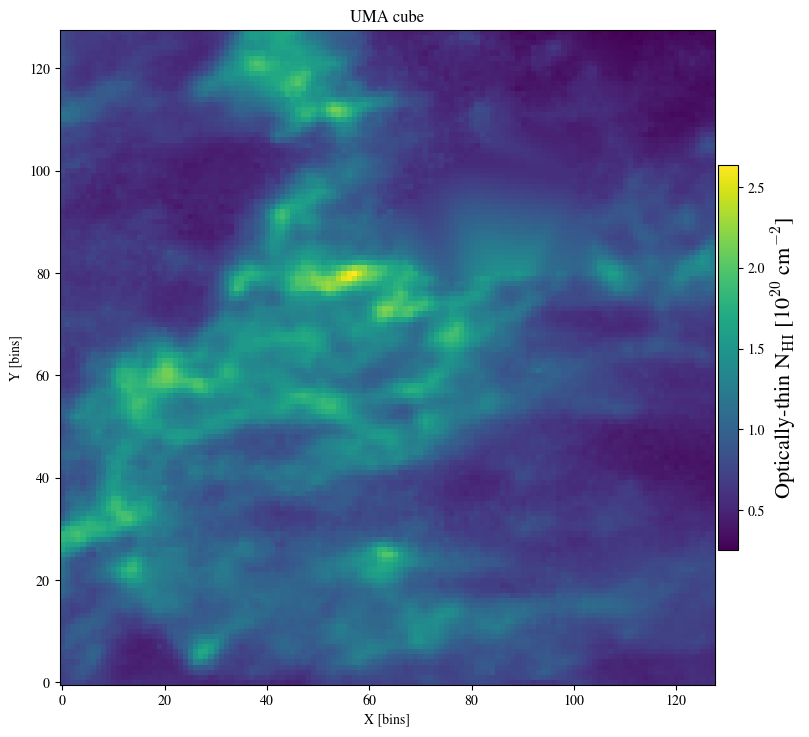

In [ ]:
m0_subcube = subcube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
nhi_thin_sc = np.array(m0_subcube)*0.018224

nhi_thin = 0.018224 * np.sum(data, axis=0) * dv


plt.figure(figsize=(10,10))
plt.imshow(nhi_thin_sc, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

## CNM cube

In [ ]:
cnm_cube, cnm_hdr = fits.getdata(uma_data_path / 'GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits', header=True)
cnm_cube.shape

(69, 128, 128)

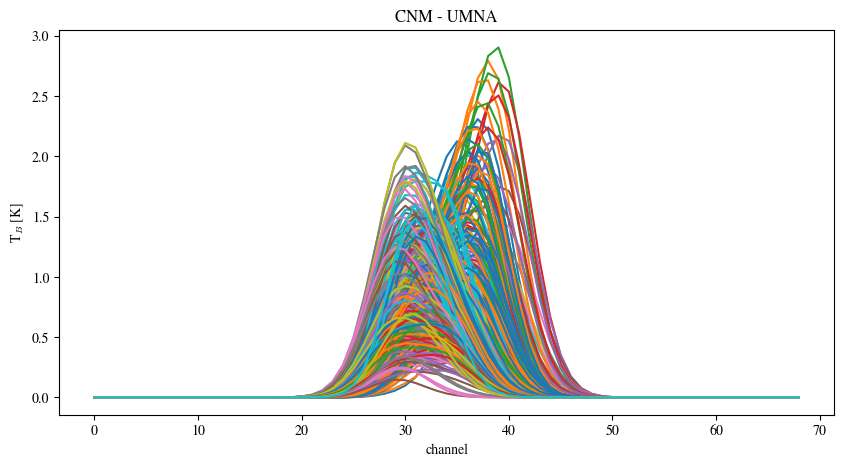

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(cnm_cube[:, 20+j, 20+i])

plt.title('CNM - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

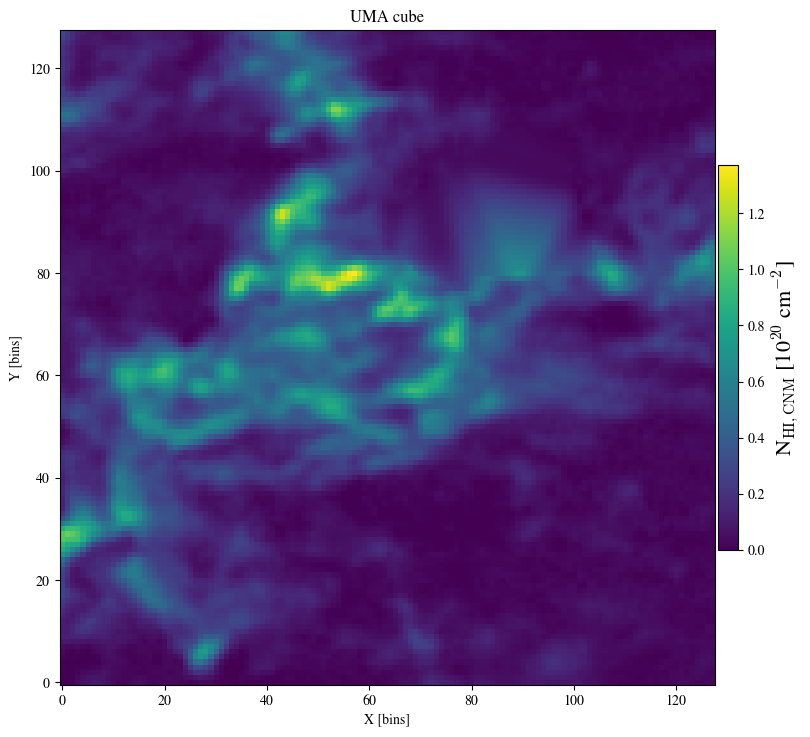

In [ ]:
# CNM - NHI
nhi_cnm = 0.018224 * np.sum(cnm_cube, axis=0) * dv

plt.figure(figsize=(10,10))
plt.imshow(nhi_cnm, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('N$_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
max_cnm_map = np.max(cnm_cube, axis=0)
cnm_cube_cor = cnm_cube.copy()
mask = (max_cnm_map < 3.5)

median_val = np.mean(nhi_cnm[mask])
nhi_cnm_cor = nhi_cnm - median_val

## WNM cube

In [ ]:
wnm_cube, wnm_hdr = fits.getdata(uma_data_path / 'GHIGLS_NCPL_Tb_WNM_IVC_n6_final.fits', header=True)
wnm_cube.shape

(69, 128, 128)

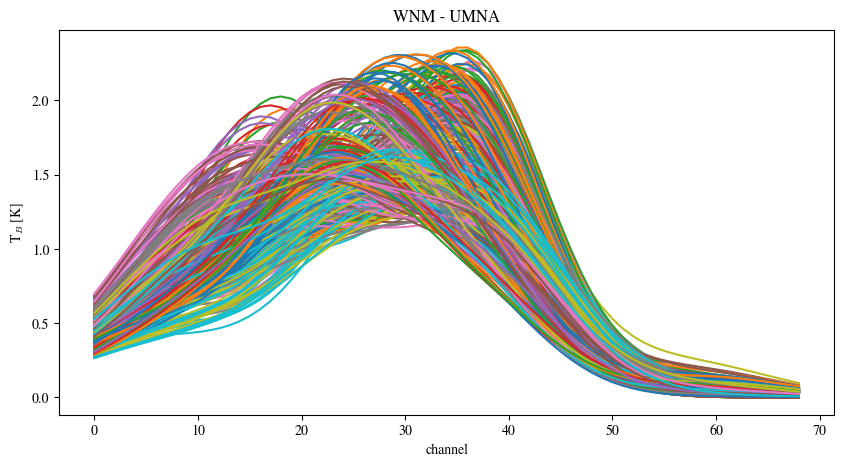

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(wnm_cube[:, 20+j, 20+i])

plt.title('WNM - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

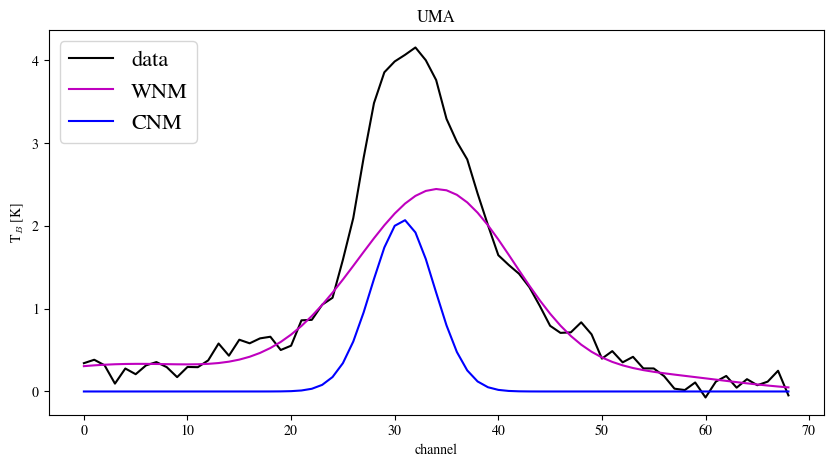

In [ ]:
i = 64
j = 64
fig = plt.figure(figsize=(10,5))

plt.plot(data[:, j, i], 'k-', label='data')
plt.plot(wnm_cube[:, j, i], 'm-', label='WNM')
plt.plot(cnm_cube[:, j, i], 'b-', label='CNM')

plt.title('UMA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')

plt.legend(loc='upper left', fontsize=16)
plt.show()

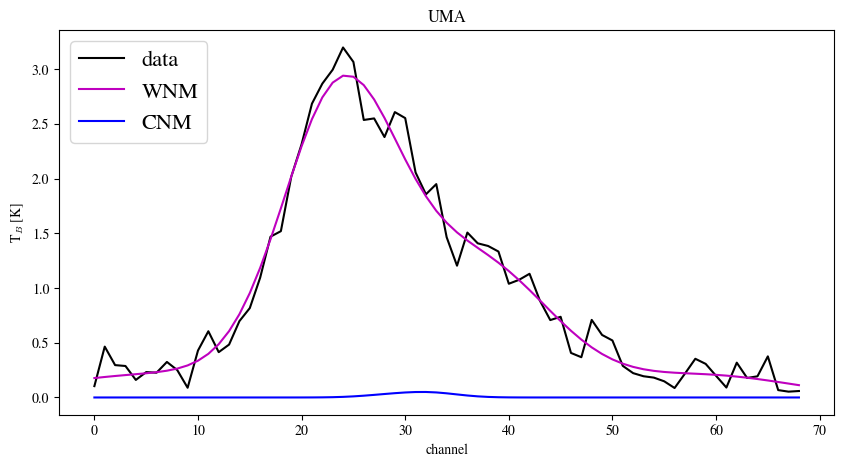

In [ ]:
i = 6
j = 4
fig = plt.figure(figsize=(10,5))

plt.plot(data[:, j, i], 'k-', label='data')
plt.plot(wnm_cube[:, j, i], 'm-', label='WNM')
plt.plot(cnm_cube[:, j, i], 'b-', label='CNM')

plt.title('UMA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')

plt.legend(loc='upper left', fontsize=16)
plt.show()

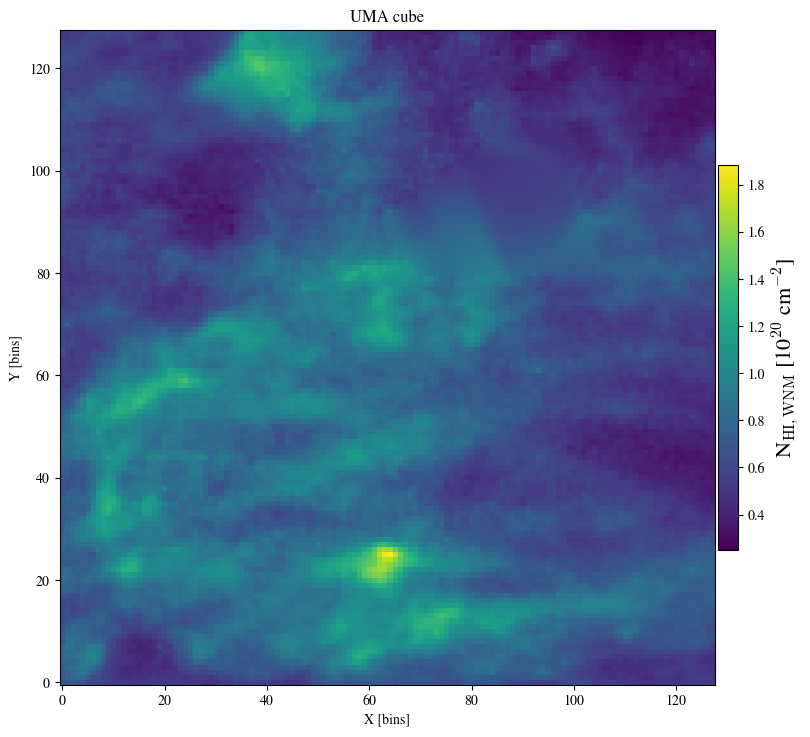

In [ ]:
# CNM - NHI
nhi_wnm = 0.018224 * np.sum(wnm_cube, axis=0) * dv

plt.figure(figsize=(10,10))
plt.imshow(nhi_wnm, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('N$_\mathrm{HI, WNM}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

## $f_\text{CNM}$ in optically-thin limit

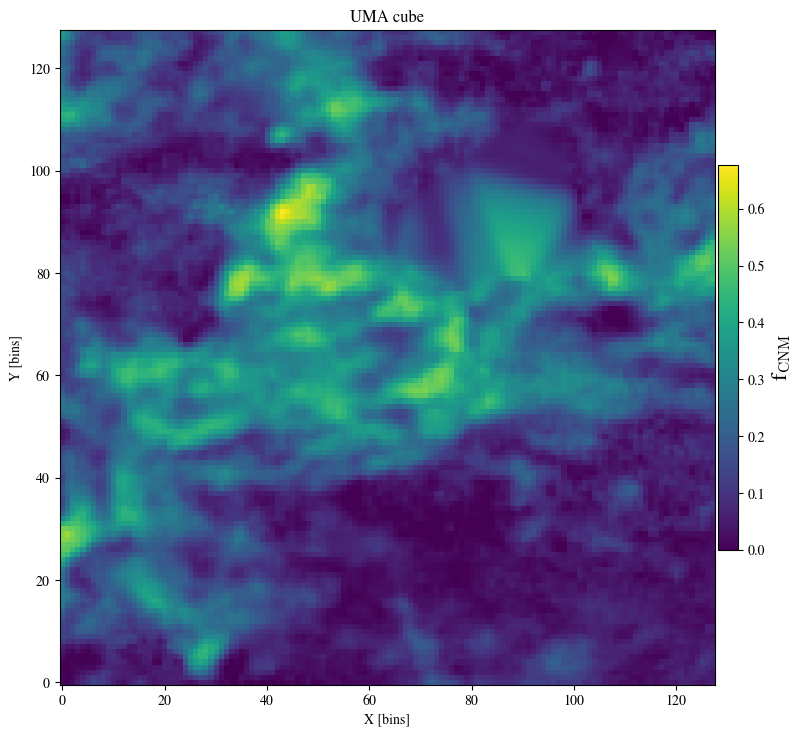

In [ ]:
fcnm_thin = nhi_cnm / nhi_thin

# CNM - NHI
plt.figure(figsize=(10,10))
plt.imshow(fcnm_thin, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('f$_\mathrm{CNM}$', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
np.savez(tanosignal_pred_path / 'uma' / f'fcnm_thin.npz', x=fcnm_thin)
print(tanosignal_pred_path / 'uma' / f'fcnm_thin.npz')

## $f_\text{CNM}$ map from Fourier Transform (FFT)

In [ ]:
cnm_data_file = uma_data_path / 'cnm_fft.fits'
print(cnm_data_file)

fft_nhi_cnm = fits.getdata(cnm_data_file) / 10. # in unit of 1e20
fft_nhi_cnm.shape

/content/gdrive/MyDrive/Colab Notebooks/ML/data/UMA/cnm_fft.fits


(128, 128)

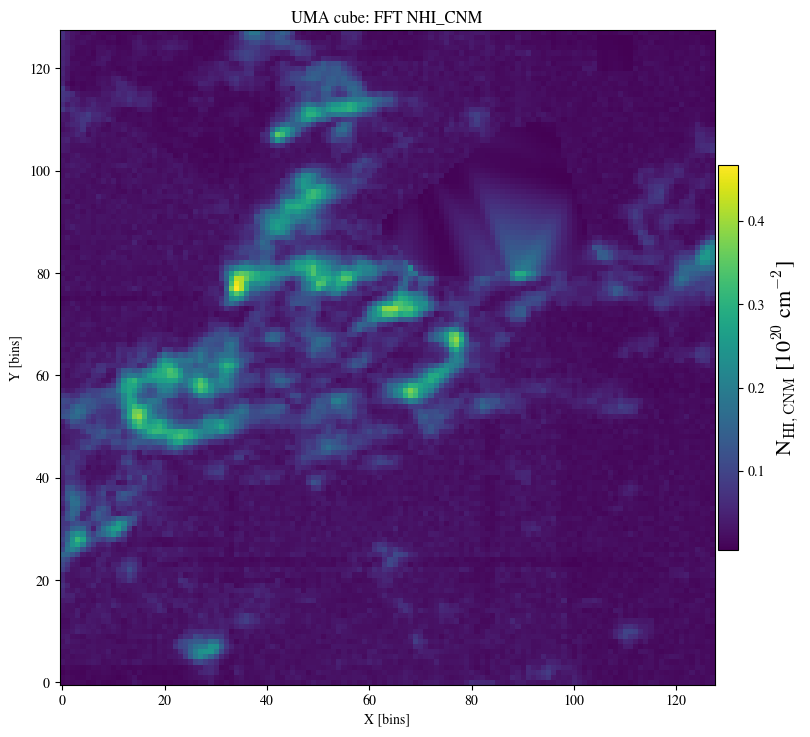

In [ ]:
# CNM - NHI
plt.figure(figsize=(10,10))
plt.imshow(fft_nhi_cnm, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('N$_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube: FFT NHI_CNM')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

## Trend when using ROHSA

In [ ]:
nhi_thin_flat   = nhi_thin.flatten()
fcnm_rohsa_flat = fcnm_thin.flatten()

# TB max
tbmax_map = np.max(data, axis=0)
tbmax_flat = tbmax_map.flatten()

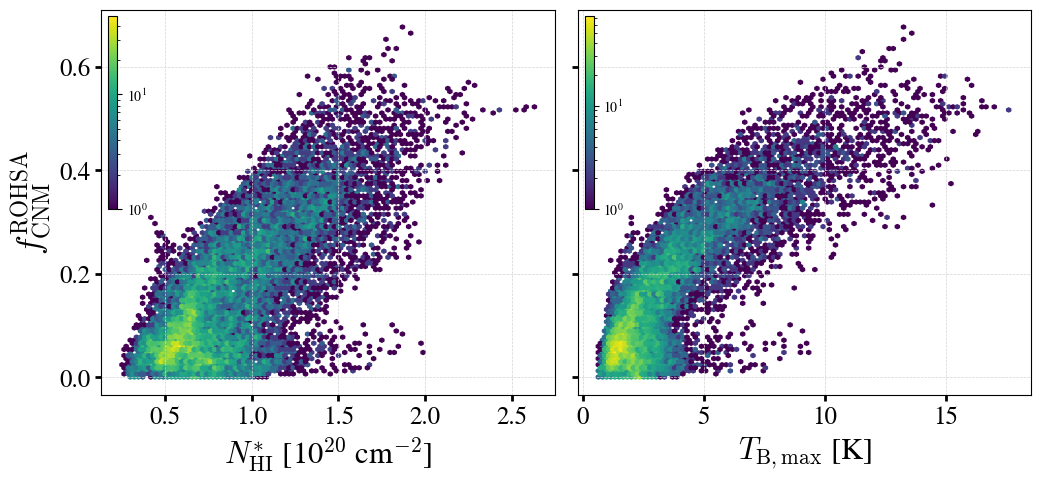

In [ ]:
# Plot
xyfontsize = 22

rows, cols = 1, 2
fig, ax = plt.subplots(rows, cols, sharex='col',  sharey='row', figsize=(12,5))


# axis 1
ax1 = ax[0]


img = ax1.hexbin(nhi_thin_flat, fcnm_rohsa_flat, gridsize=100, cmap='viridis', norm=LogNorm()) # cividis

axins1 = inset_axes(ax1,
                    width="2%",
                    height="50%",
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=16)



ax1.set_xlabel(r'$N^{*}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=xyfontsize)
ax1.set_ylabel(r'${f^\mathrm{ROHSA}_\mathrm{CNM}}$', fontsize=xyfontsize+2, fontweight='normal')

ax1.tick_params(axis='x', labelsize=18, pad=4)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)
ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)






# Axis 2
ax2 = ax[1]

img = ax2.hexbin(tbmax_flat, fcnm_rohsa_flat, gridsize=100, cmap='viridis', norm=LogNorm())

axins1 = inset_axes(ax2,
                    width="2%",
                    height="50%",
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=16)

ax2.set_xlabel(r'$T_\mathrm{B, max}$ [K]', fontsize=xyfontsize)

ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.05,
                    hspace=0.
                    )

plt.show()
plt.close()

# FCNM map from FFT

In [ ]:
cnm_data_file = uma_data_path / 'cnm_fft.fits'
print(cnm_data_file)

fft_nhi_cnm = fits.getdata(cnm_data_file) / 10. # in unit of 1e20
fft_nhi_cnm.shape

/content/gdrive/MyDrive/Colab Notebooks/ML/data/UMA/cnm_fft.fits


(128, 128)

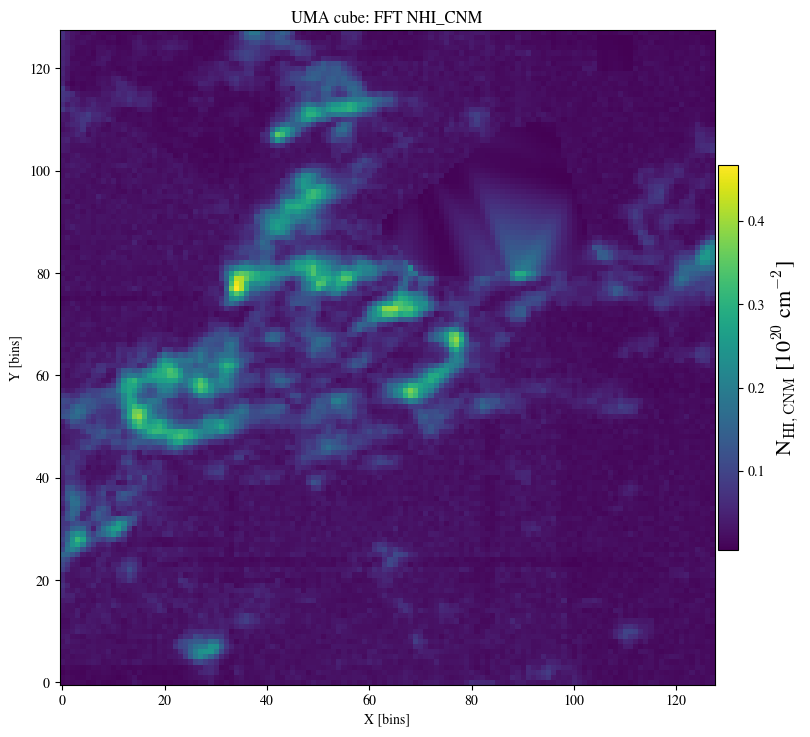

In [ ]:
# CNM - NHI
plt.figure(figsize=(10,10))
plt.imshow(fft_nhi_cnm, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('N$_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube: FFT NHI_CNM')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
fft_fcnm = fft_nhi_cnm / nhi_thin
fcnm_fft_flat = fft_fcnm.flatten()

# Data preprocessing

In [ ]:
nchan, ny, nx = datacube.shape

In [ ]:
num = ny*nx
num

16384

In [ ]:
# TB max
tbmax_map = np.max(data, axis=0)
tbmax_flat = tbmax_map.flatten()

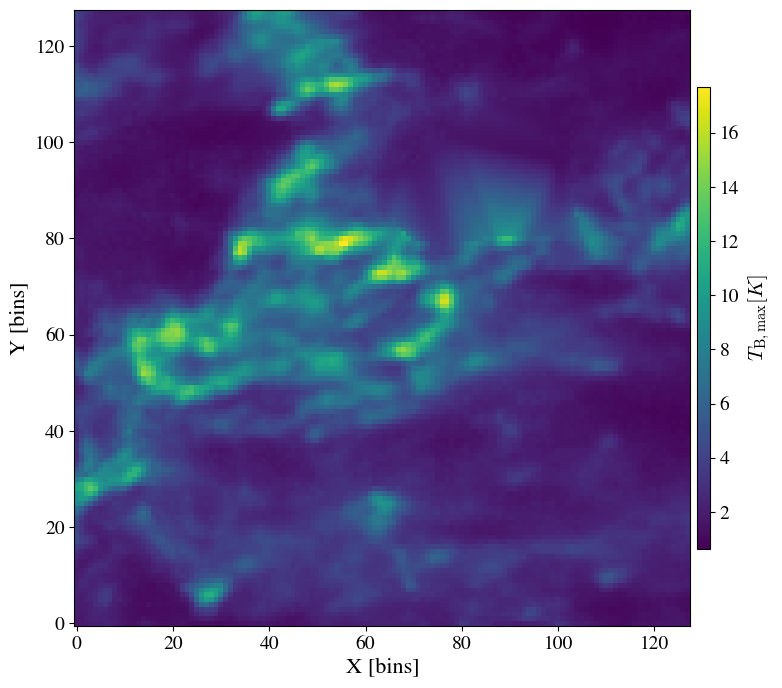

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(tbmax_map, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$T_\mathrm{B, max} [K]$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

# To new channel grid

In [ ]:
x = np.linspace(0, nchan, nchan, endpoint=False)
x[-3:]

In [ ]:
# Interpolate into new vlsr channel grid
nchan_new = 256
x_new = np.linspace(0, nchan, nchan_new, endpoint=True)

new_cube = np.zeros((nchan_new, ny, nx))
for i,j in np.ndindex(nx,ny):
    new_cube[:, j, i] = np.interp(x_new, x, datacube[:, j, i])

# CNN-transformer model

In [ ]:
pe_list = ['original_vector', 'index_add', 'index_concate', 'poly_concate', 'sin_add', 'sin_concate', 'learnable_add']

In [ ]:
if 'cnn_trans' in locals():
    del cnn_trans

# CNN-Transformer model
pev = 'sin_add'
input_column = 256

num_output  = 2
dropout     = 0.

# Model
cnn_trans = CNN_Transformer(pev, num_output, input_column, dropout, device)

# Load weights
weight_cp_file = ct101_checkpoint_path / f'ctrans_{pev}_10_{input_column}_final.pth'
cnn_trans.load_weights(weight_cp_file)

In [ ]:
# fcnm, rhi = cnn_trans.predict(new_cube)
# np.savez(tanosignal_pred_path / 'uma' / f'ctrans_{pev}_fcnm_rhi.npz', x=fcnm, y=rhi)

In [ ]:
temp_data = np.load(tanosignal_pred_path / 'uma' / f'ctrans_{pev}_fcnm_rhi.npz')
fcnm = temp_data['x']
rhi = temp_data['y']
temp_data.close()
del temp_data

In [ ]:
nhi_cnm_ct = fcnm*nhi_thin_sc

## tpcNet: $F_{CNM}$ map

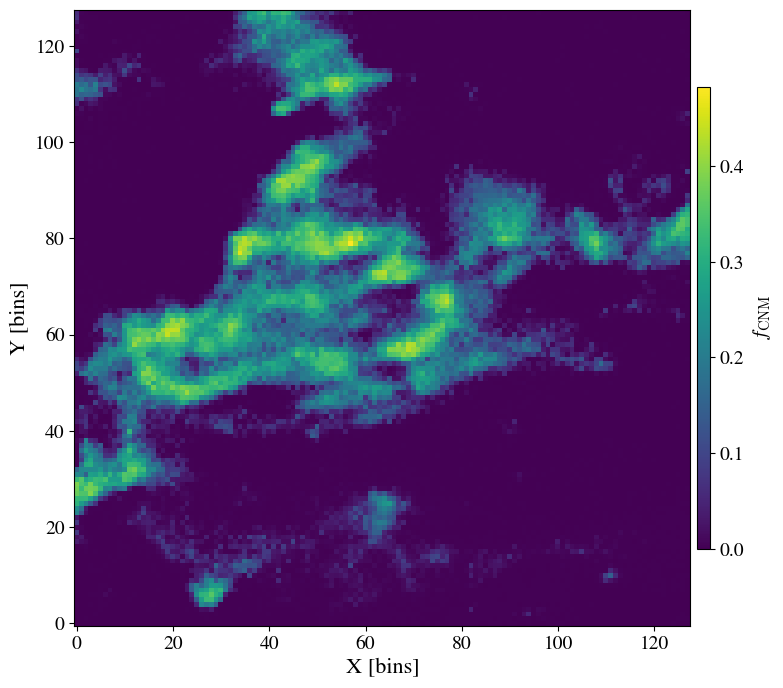

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(fcnm, cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

## tpcNet: $R_\text{HI}$ map

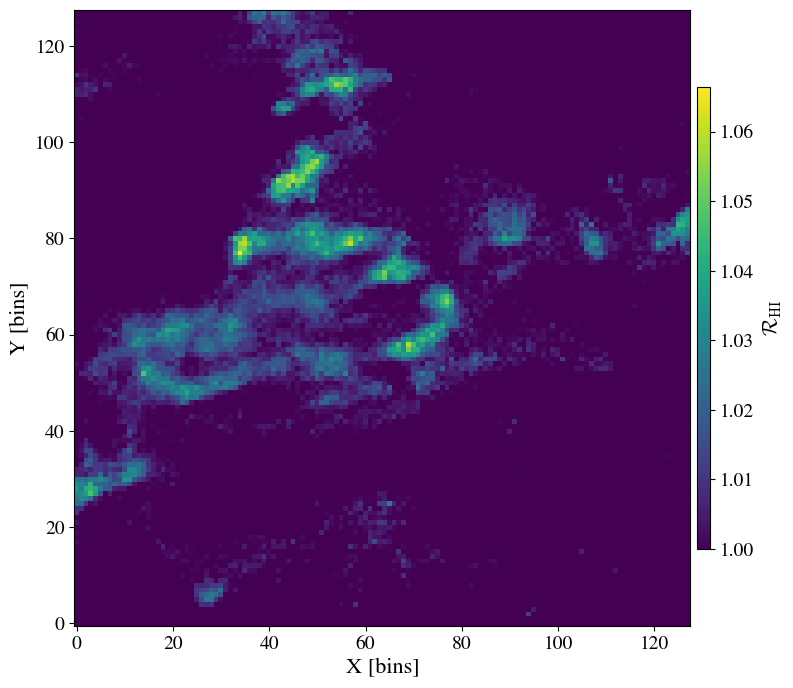

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(rhi, cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathcal{R}_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
# fig.savefig(filename.replace('.FITS', '_zoom.jpg'), bbox_inches='tight')   # save the figure to file
plt.show()
plt.close()

In [ ]:
print(np.min(fcnm))
print(np.median(fcnm))
print(np.max(fcnm))

0.0
0.003446664661169052
0.48296064138412476


In [ ]:
Fcnm_flat = fcnm.flatten()
Rhi_flat = rhi.flatten()

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = np.squeeze(fcnm)
y_gt = np.squeeze(fcnm_thin)

fcnm_diff = y_gt - y_pred

fcnm_mse = mean_squared_error(y_gt, y_pred)
print(fcnm_mse, np.sqrt(fcnm_mse))


y_pred_flat = y_pred.flatten()
y_gt_flat   = y_gt.flatten()

0.018158302172121617 0.13475274458103484


In [ ]:
Fcnm_gt_flat = fcnm_thin.flatten()

# tpcNet predictions: Figure 11

<ipython-input-206-d71ea390bf02>:311: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


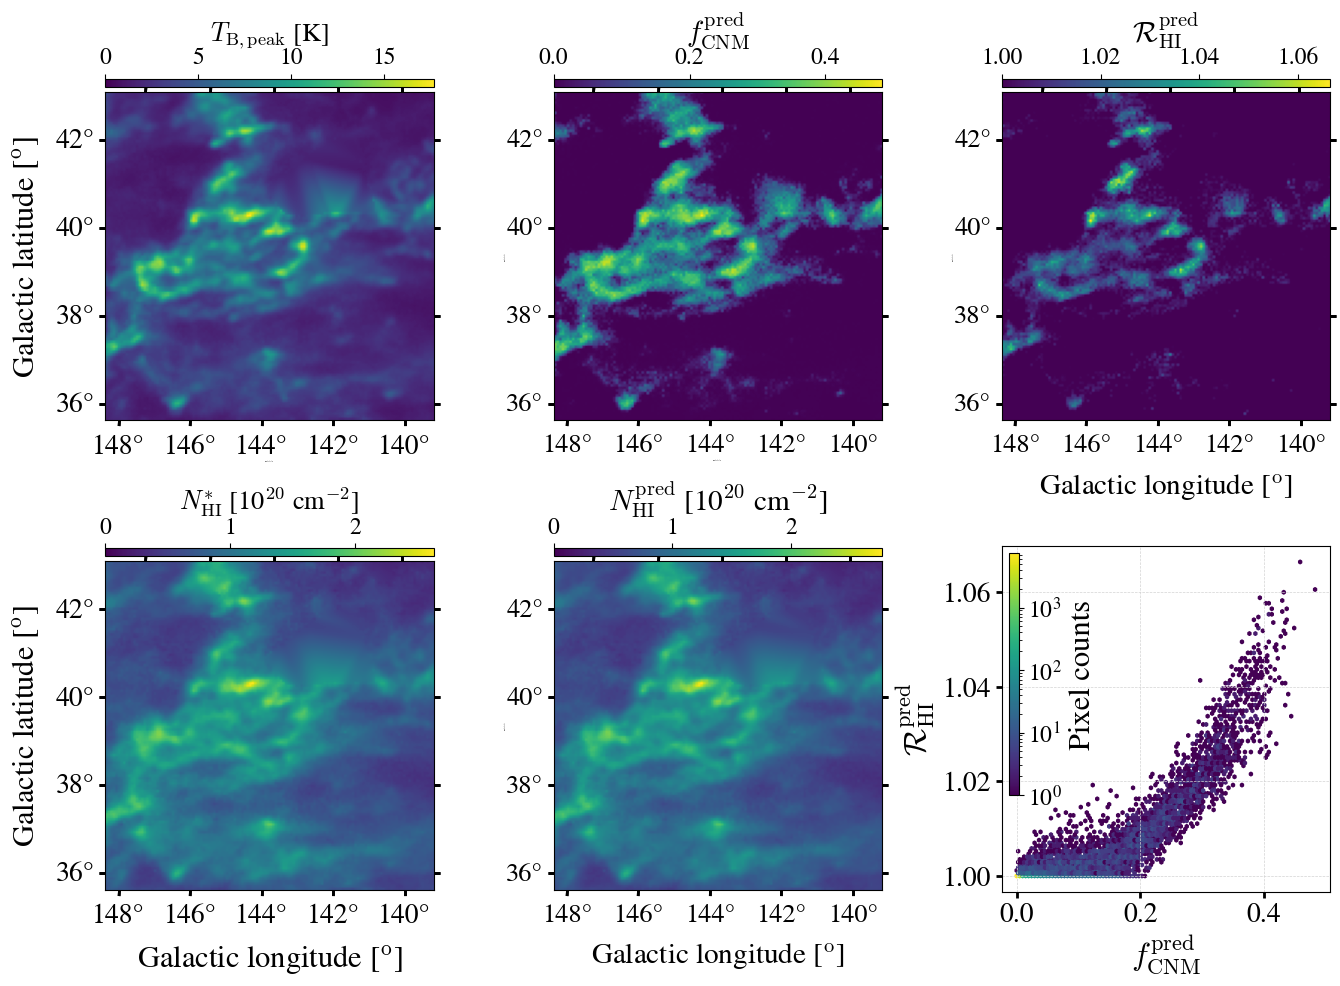

In [ ]:
fig = plt.figure(figsize=(13.5,10))

####
ax = fig.add_subplot(231, projection=wcs2D)

# moment map image
im = ax.imshow(tbmax_map, cmap='viridis', origin='lower', vmin=0.)

# Add axes labels
ax.set_xlabel("", fontsize=0)
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=22)

ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("top", size="2.5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.75, fraction=0.1, pad=0.005, aspect=40)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$T_\mathrm{B, peak}$ [K]', rotation=0, labelpad=5., fontsize=19)





ax = fig.add_subplot(232, projection=wcs2D)


# moment map image
im = ax.imshow(fcnm, cmap='viridis', origin='lower', vmin=0.)


# Add axes labels
ax.set_xlabel("", fontsize=0)
ax.set_ylabel("", fontsize=0)

ax.tick_params(axis='x', labelsize=19, pad=4)
ax.tick_params(axis='y', labelsize=19)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("top", size="2.5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.75, fraction=0.1, pad=0.005, aspect=40)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$f^\mathrm{pred}_\mathrm{CNM}$', rotation=0, labelpad=5., fontsize=21)







ax = fig.add_subplot(233, projection=wcs2D)

# moment map image
im = ax.imshow(rhi, cmap='viridis', origin='lower', vmin=1.)

# Add axes labels
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=21)
ax.set_ylabel("", fontsize=0)

ax.tick_params(axis='x', labelsize=19, pad=4)
ax.tick_params(axis='y', labelsize=19)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("top", size="2.5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.75, fraction=0.1, pad=0.005, aspect=40)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$\mathcal{R}^\mathrm{pred}_\mathrm{HI}$', rotation=0, labelpad=5., fontsize=21)








####
ax = fig.add_subplot(234, projection=wcs2D)


# moment map image
im = ax.imshow(nhi_thin, cmap='viridis', origin='lower', vmin=0.)


# Add axes labels
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=22)
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=22)

ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

# Create a gridspec for the colorbar
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("top", size="2.5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.75, fraction=0.1, pad=0.005, aspect=40)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$N^{*}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=0, labelpad=5., fontsize=19)







####
ax = fig.add_subplot(235, projection=wcs2D)

# moment map image
im = ax.imshow(rhi*nhi_thin, cmap='viridis', origin='lower', vmin=0.)

# Add axes labels
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=21)
ax.set_ylabel("", fontsize=0)

ax.tick_params(axis='x', labelsize=19, pad=4)
ax.tick_params(axis='y', labelsize=19)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("top", size="2.5%", pad=0.05, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.75, fraction=0.1, pad=0.005, aspect=40)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$N^\mathrm{pred}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=0, labelpad=5., fontsize=21)





####
ax = fig.add_subplot(236)

img = ax.hexbin(Fcnm_flat, Rhi_flat, gridsize=100, cmap='viridis', norm=LogNorm())

axins1 = inset_axes(ax,
                    width="3%",
                    height="70%",
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('Pixel counts', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=17)

ax.set_xlabel(r'$f^\mathrm{pred}_\mathrm{CNM}$', fontsize=23)
ax.set_ylabel(r'${\mathcal{R}^\mathrm{pred}_\mathrm{HI}}$', fontsize=23, fontweight='normal')

ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.0001,
                    hspace=0.15
                    )

plt.tight_layout()
plt.show()
plt.savefig(img_path / 'uma_fcnm_rhi_nhi_ct.png', bbox_inches='tight', pad_inches=0.09, format='png' , dpi=150)
plt.close()